# Base de datos de Diabetes de los Indios Pima. Predecir la aparición de diabetes según las medidas de diagnóstico.

* Contexto: Este conjunto de datos es originalmente del Instituto Nacional de Diabetes y Enfermedades Digestivas y Renales. Se impusieron varias restricciones a la selección de estas instancias de una base de datos más grande. En particular, todos los pacientes aquí son mujeres de al menos 21 años de edad de origen indio Pima.

*  El objetivo del conjunto de datos es predecir de forma diagnóstica si un paciente tiene diabetes o no, basándose en determinadas medidas de diagnóstico incluidas en el conjunto de datos.


* Enlace de la BBDD: https://www.kaggle.com/uciml/pima-indians-diabetes-database


* Sobre el Dataset se tienen las siguientes características:

    - Pregnancies: número de embarazos.
    - Glucose: concentración de glucosa en plasma a 2 horas en una prueba de tolerancia a la glucosa oral.
    - BloodPressure: presión arterial diastólica (mm Hg).
    - SkinThickness: Espesor del pliegue cutáneo del tríceps (mm).
    - Insulin: insulina sérica de 2 horas (mu U / ml).
    - BMI:(IMC) índice de masa corporal (peso en kg / (altura en m) ^ 2).
    - DiabetesPedigreeFunction: función del pedigrí de la diabetes.
    - Age: Edad (años).
    - Outcome: Sería la variable de salida, 1 = Enfermo, 0 = Sano.


* En este ejercicio ***se realizará una regresión logística*** para que genere un modelo que sea capaz de clasificar a un paciente indicando si sufre o no una diabetes.


* Para ello hay que tomar las variables de entrada que se consideren y como variable de salida la variable: Outcome.


* Para resolver este problema vamos a realizar los siguientes pasos:
<span></span><br>
    1. Carga del dataset y breve explicación y/o relación de las variables.
        + 1.1 Carga del dataset.
        + 1.2 Visulalización de los datos.
        + 1.3 Limpieza de los datos
        + 1.4 Transformación - Codificación One Hot Encoder - nuevas columnas categóricas.
        + 1.5 Normalización resto de las columnas.
<span></span><br>
    2. Instancia y ajuste del modelo.
        + 2.1 Cambio de la estructura de datos a numpy.
        + 2.2 Particionado de datos en Entrenamiento y Test
        + 2.3 Creacción del modelo (hipótesis) y ajuste con los datos de Entrenamiento
<span></span><br>
    3. Evaluación del modelo (Datos de Entrenamiento y Test).
        + Accuracy
        + Precision
        + Recall
        + F1
<span></span><br>
    4. Visualización de los resultados.
        + Dibujar Matriz de confusión
<span></span><br>
    5. Conclusiones y Justificación de los resultados.
<hr>


* En primer lugar vamos a importar las librerías necesarias:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,classification_report
%matplotlib inline

from pandas_profiling import ProfileReport
from scipy import stats as st

# Propiedad de pandas para visualizar todas las columnas del DataFrame
pd.set_option('display.max_columns', None)

# Ignoramos los warnings (para pandas)
warnings.filterwarnings('ignore')


## 1. Carga del dataset y breve explicación y/o relación de las variables.


### 1.1 Carga del dataset


* Los datos se encuentran en el fichero: ***"diabetes.csv"***

In [2]:
df = pd.read_csv("diabetes.csv")
df.sample(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
341            1       95             74             21       73  25.9   
75             1        0             48             20        0  24.7   
752            3      108             62             24        0  26.0   
670            6      165             68             26      168  33.6   
608            0      152             82             39      272  41.5   

     DiabetesPedigreeFunction  Age  Outcome  
341                     0.673   36        0  
75                      0.140   22        0  
752                     0.223   25        0  
670                     0.631   49        0  
608                     0.270   27        0


### 1.2. Visualización de los datos


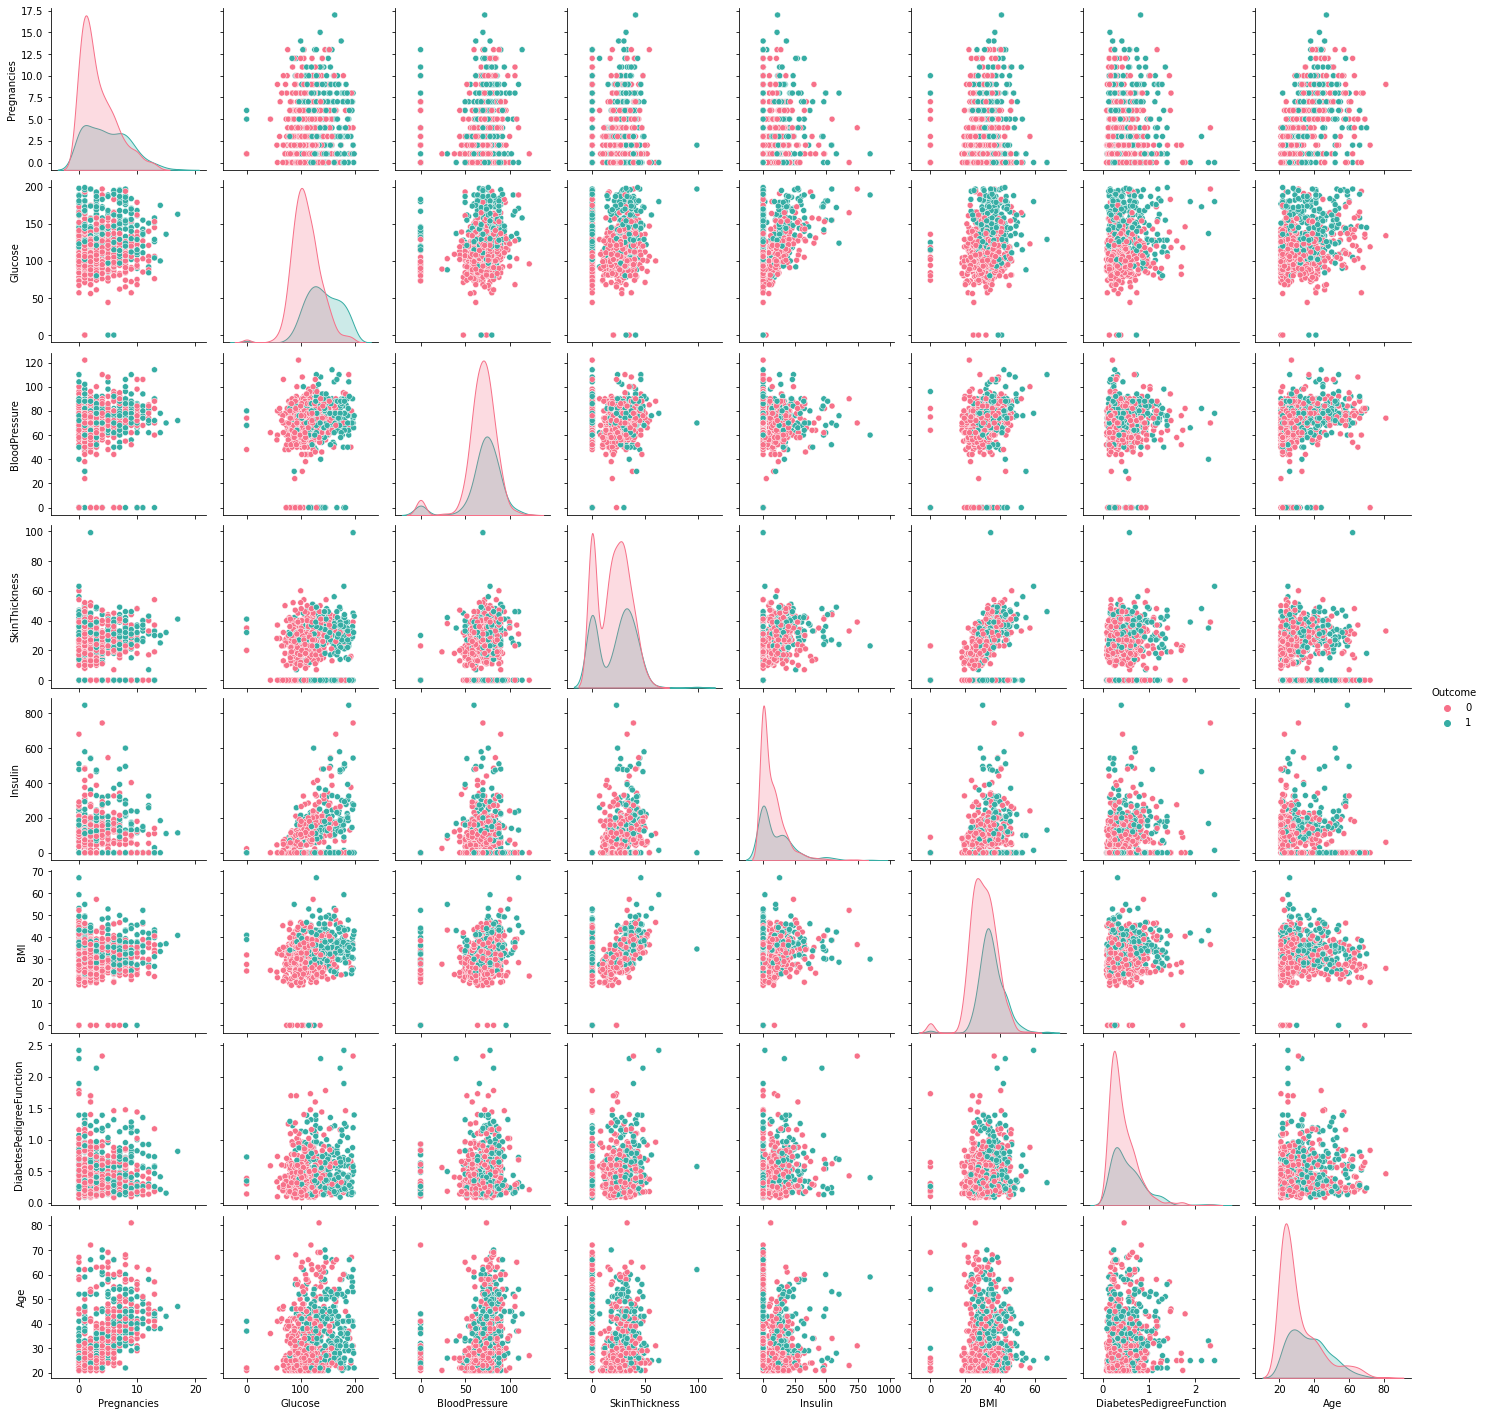

In [3]:
sns.pairplot(df, hue="Outcome", palette="husl")

#### Conclusión: Al visualizar los datos cabe destacar (2ª fila) en caso de la variable de la glucosa hay una mayor concentración de puntos verdes (Enfermos de diabetes) en los valores más altos frente a los no enfermos rojos, con valores menores. También vemos los valores ceros en algunas variables que explicaremos a continuación no pueden tener este valor y deberemos corregir.

### 1.3 Limpieza de los datos

Aplicamos ProfileReport para tener una visión generalizada del dataset:

In [4]:
# Creamos el reporte
profile = ProfileReport(df=df, title='Profiling Report Diabetes', explorative=True)

# Lo exportamos a HTML
profile.to_file("./resultados/Reporte_Diabetes.html")

# Mostramos el reporte por pantalla
profile

### Tareas de limpieza a realizar, tras ProfileReport:
* Breve resumen: Es un dataset con 9 columnas(8 numéricas, 1 Bool), ***sin datos faltantes, sin variables correladas***. Lo que ***debemos corregir*** son los ***zeros*** de algunas columnas que pasamos a detallar:
<span></span><br>
+ ***1.3.1 Limpieza columna "Glucose"***: esta variable mide la concentración de glucosa en plasma a las 2 horas de una prueba de tolerancia a la glucosa oral. Por lo que no puede tener valor cero. En este caso vemos que existen 5 valores que suponen el 0.7%.
   + El primer cambio que haremos será aplicar, según sea el registrro de la clase enfermo o no enfermo de diabétes la media o mediana atendiendo a la desviación.
   + Desde un enfoque de la diabetes (según análisis clínicos), también crearemos una columna en base a:
       + Un nivel de glucosa sanguínea inferior a 140 mg/dl (7,8 mmol/l) se considera ***normal***.
       + Un nivel de glucosa sanguínea de entre 140 y 199 mg/dl (7,8 a 11 mmol/l) se considera ***prediabetes***.
       + Un nivel de glucosa sanguínea de 200 mg/dl (11,1 mmol/l) o superior indica ***diabetes tipo 2***.
<span></span><br>
+ ***1.3.2 Limpieza columna "BloodPressure"***: esta variable mide presión arterial diastólica (mm Hg). La presión arterial diastólica es la que conocemos habitualmente como la medición inferior (Medición de tensión: la alta y la baja), lo normal es que este por debajo de 80 pero no puede tener valor cero ya que sino la persona estaría muerta. En este caso vemos que existen 35 valores que suponen el 4.6%.
   + En este cambio también aplicaremos, según sea el registrro de la clase enfermo o no enfermo de diabétes la media o mediana atendiendo a la desviación.
<span></span><br>
+ ***1.3.3 Limpieza columna "SkinThickness"***: esta variable mide el espesor del pliegue cutáneo del tríceps (mm). El pliegue cutáneo mide indirectamente el grosor del tejido adiposo subcutáneo, y se utiliza para predecir la densidad corporal y calcular la masa grasa y la masa libre de grasa. No puede tener valor de cero. En este caso vemos que existen 227 valores que suponen el 29,6%.
   + En este cambio también aplicaremos, según sea el registrro de la clase enfermo o no enfermo de diabétes la media o mediana atendiendo a la desviación.
<span></span><br>
+ ***1.3.4 Limpieza columna "Insulin"***: esta variable mide la insulina sérica de 2 horas (mu U/ml). Es una prueba que mide cuánta insulina tiene en la sangre. La insulina es una hormona que permite que el azúcar en la sangre, conocido como glucosa, pase a las células. La glucosa proviene de los alimentos y las bebidas que consume. Es la principal fuente de energía del cuerpo. La insulina juega un papel clave en el mantenimiento de niveles correctos de glucosa en la sangre. Si están demasiado altos o bajos, eso puede causar problemas de salud graves. Los niveles anormales de glucosa se conocen como: ***Hipoglucemia: valores por debajo de:16 (mu U/ml) y Hiperglucemia: valores por encima de 166 (mu U/ml)***. No puede tener valor de cero y en este caso vemos que existen 374 valores que suponen el 48,7%.
   + El cambio que haremos será aplicar, según sea enfermo o no enfermo de diabétes la media o mediana atendiendo a la desviación.
   + Además crearemos nueva columna en base a los valores normales y los valores no normales (menor de 16 y mayor de 166).
<span></span><br>
+ ***1.3.5 Limpieza columna "BMI"***: esta variable es más conocida, mide(IMC) índice de masa corporal (peso en kg / (altura en m) ^ 2). No puede tener valor de cero y en este caso vemos que existen 11 valores que suponen el 1,4%.
   + El cambio que haremos será aplicar, según sea enfermo o no enfermo de diabétes la media o mediana atendiendo a la desviación.
   + Además crearemos nueva columna en base a la siguiente tabla de clasificación del ICM(Kg/m^2):
<figure>
  <img src="Imagenes/imc_tabla.jpg"
       alt="Imagen de la tabla clasificación imc.jpg" width="350">
</figure>
<span></span><br>
* En el resto de variables no haremos cambios, los valores pueden ser posibles. 

#### 1.3.1 Limpieza Columna Glucose

In [5]:
df.groupby(['Outcome'])['Glucose'].agg(['median','mean','std']).reset_index()

Outcome  median        mean        std
0        0     107  109.980000  26.141200
1        1     140  141.257463  31.939622

Atendiendo al valor de la desviación tan elevado , tomaremos como referencia para los valores cero la mediana.

In [6]:
df['Glucose_OK'] = df.apply(lambda row: 107 if row.Glucose == 0 and row.Outcome == 0
                                        else (140 if row.Glucose == 0 and row.Outcome == 1 
                                              else row.Glucose) 
                                        , axis=1)

Creamos la nueva columna en base a los niveles de glucosa en sangre, indicados en descriptivo de limpieza, según estudios de análisis clínicos:

In [7]:
df['Glucosa_n']=df.apply(lambda 
                                   row:'Glu_Normal' if row.Glucose_OK<140
                                  else('Glu_Prediabetico' if row.Glucose_OK>=140 and row.Glucose_OK<=199
                                      else 'Glu_diabetico')
                                  ,axis=1)

#### 1.3.2 Limpieza Columna BloodPressure

In [8]:
df.groupby(['Outcome'])['BloodPressure'].agg(['median','mean','std']).reset_index()

Outcome  median       mean        std
0        0      70  68.184000  18.063075
1        1      74  70.824627  21.491812

Atendiendo al valor de la desviación tan elevado , tomaremos como referencia para los valores cero la mediana.

In [9]:
df['BloodPressure_OK'] = df.apply(lambda row: 70 if row.BloodPressure == 0 and row.Outcome == 0
                                        else (74 if row.BloodPressure == 0 and row.Outcome == 1 
                                              else row.BloodPressure) 
                                        , axis=1)

#### 1.3.3 Limpieza Columna SkinThickness

In [10]:
df.groupby(['Outcome'])['SkinThickness'].agg(['median','mean','std']).reset_index()

Outcome  median       mean        std
0        0      21  19.664000  14.889947
1        1      27  22.164179  17.679711

Atendiendo al valor de la desviación tan elevado , tomaremos como referencia para los valores cero la mediana.

In [11]:
df['SkinThickness_OK'] = df.apply(lambda row: 21 if row.SkinThickness == 0 and row.Outcome == 0
                                        else (27 if row.SkinThickness == 0 and row.Outcome == 1 
                                              else row.SkinThickness) 
                                        , axis=1)

#### 1.3.4 Limpieza Columna Insulin

In [12]:
df.groupby(['Outcome'])['Insulin'].agg(['median','mean','std']).reset_index()

Outcome  median        mean         std
0        0      39   68.792000   98.865289
1        1       0  100.335821  138.689125

Atendiendo al valor de la desvisción tan elevada debemos aplicar la mediana, pero para el caso de los enfermos no podemos aplicar el cero, porque sabemos que no es un valor real. En este caso,  partiendo de la base que ha de ser un valor anormal, si nos fijamos en el reporte de profile, en esta variable en el apartado de valores extremos, el valor minimo es 14, por lo que aplicaremos este valor para estos casos.

In [13]:
df['Insulin_OK'] = df.apply(lambda row: 39 if row.Insulin == 0 and row.Outcome == 0
                                        else (14 if row.Insulin == 0 and row.Outcome == 1 
                                              else row.Insulin) 
                                        , axis=1)

Creamos nueva columna en base a los niveles normales y anormales de insulina.

In [14]:
df['Insulina_n']=df.apply(lambda row:'Ins_Normal' if row.Insulin_OK>=16 and row.Insulin_OK<=166
                                  else'Ins_Anormal', axis=1)

#### 1.3.5 Limpieza Columna BMI

In [15]:
df.groupby(['Outcome'])['BMI'].agg(['median','mean','std']).reset_index()

Outcome  median       mean       std
0        0   30.05  30.304200  7.689855
1        1   34.25  35.142537  7.262967

Atendiendo al valor de la desviación tan elevado , tomaremos como referencia para los valores cero la mediana.

In [16]:
df['BMI_OK'] = df.apply(lambda row: 30 if row.BMI == 0 and row.Outcome == 0
                                        else (34 if row.BMI == 0 and row.Outcome == 1 
                                              else row.BMI) 
                                        , axis=1)

Creamos nueva columna en base a la clasificación del IMC:

In [17]:
df['BMI_n'] = df.apply(lambda row: 'BMI_BajoPeso' if row.BMI_OK < 18.50
                                        else ('BMI_Normal' if row.BMI_OK >= 18.50 and row.BMI_OK  <= 24.99
                                              else ('BMI_Sobrepeso' if row.BMI_OK > 24.99 and row.BMI_OK  <= 29.99
                                                   else('BMI_ObesoI' if row.BMI_OK > 29.99 and row.BMI_OK  <= 34.99
                                                       else('BMI_ObesoII' if row.BMI_OK > 34.99 and row.BMI_OK  <= 39.99
                                                           else('BMI_ObesoIII')))))
                                        , axis=1)

Realizamos un describe, para comprobar que los mínimos de las nuevas columnas númericas, creadas ya no son cero:

In [18]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  \
count  768.000000                768.000000  768.000000  768.000000   
mean    31.992578                  0.471876   33.240885    0.348958   
std      7.884160                  0.331329   11.760232    0.476951   
min      0.000000                  0.078000   21.000000    0.000000   
25%     27.300000                  0.243750   24.000000    0.000000   
50%     32.000000                  0.372500   29.000000    0.000000   
75%     36.600000                  0.626250   41.000000    1.000000   
max     67.100000                  2.420000   81.000000    1.000000   

       Glucose_OK  BloodPressure_OK  SkinThickness_OK  Insulin_OK      BMI_OK  
count  768.000000        768.000000         768.00000  768.000000  768.000000  
mean   121.677083         72.378906          27.43099   94.299479   32.432682  
std     30.464161         12.104431           9.32146  106.097684    6.880709  
min     44.000000         24.000000           7.00000   14.000000   18.200000  
25%     99.750000         64.000000          21.00000   39.000000   27.500000  
50%    117.000000         72.000000          27.00000   39.000000   32.050000  
75%    140.250000         80.000000          32.00000  127.250000   36.600000  
max    199.000000        122.000000          99.00000  846.000000   67.100000

### 1.4 Transformación - Codificación One Hot Encoder - nuevas columnas categóricas

In [19]:
df_dummy=pd.get_dummies(df, columns=['Glucosa_n','Insulina_n','BMI_n'])
df_dummy

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  Glucose_OK  BloodPressure_OK  \
0                       0.627   50        1       148.0                72   
1                       0.351   31        0        85.0                66   
2                       0.672   32        1       183.0                64   
3                       0.167   21        0        89.0                66   
4                       2.288   33        1       137.0                40   
..                        ...  ...      ...         ...               ...   
763                     0.171   63        0       101.0                76   
764                     0.340   27        0       122.0                70   
765                     0.245   30        0       121.0                72   
766                     0.349   47        1       126.0                60   
767                     0.315   23        0        93.0                70   

     SkinThickness_OK  Insulin_OK  BMI_OK  Glucosa_n_Glu_Normal  \
0                  35          14    33.6                     0   
1                  29          39    26.6                     1   
2                  27          14    23.3                     0   
3                  23          94    28.1                     1   
4                  35         168    43.1                     1   
..                ...         ...     ...                   ...   
763                48         180    32.9                     1   
764                27          39    36.8                     1   
765                23         112    26.2                     1   
766                27          14    30.1                     1   
767                31          39    30.4                     1   

     Glucosa_n_Glu_Prediabetico  Insulina_n_Ins_Anormal  \
0                             1                       1   
1                             0                       0   
2                             1                       1   
3                             0                       0   
4                             0                       1   
..                          ...                     ...   
763                           0                       1   
764                           0                       0   
765                           0                       0   
766                           0                       1   
767                           0                       0   

     Insulina_n_Ins_Normal  BMI_n_BMI_BajoPeso  BMI_n_BMI_Normal  \
0                        0                   0                 0   
1                        1                   0                 0   
2                        0                   0                 1   
3                        1                   0                 0   
4                        0                   0                 0   
..                     ...                 ...               ...   
763                      0                   0                 0   
764                      1                   0                 0   
765                      1                   0                 0 

In [20]:
df=df_dummy.drop(columns=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']).copy()
df

Pregnancies  DiabetesPedigreeFunction  Age  Outcome  Glucose_OK  \
0              6                     0.627   50        1       148.0   
1              1                     0.351   31        0        85.0   
2              8                     0.672   32        1       183.0   
3              1                     0.167   21        0        89.0   
4              0                     2.288   33        1       137.0   
..           ...                       ...  ...      ...         ...   
763           10                     0.171   63        0       101.0   
764            2                     0.340   27        0       122.0   
765            5                     0.245   30        0       121.0   
766            1                     0.349   47        1       126.0   
767            1                     0.315   23        0        93.0   

     BloodPressure_OK  SkinThickness_OK  Insulin_OK  BMI_OK  \
0                  72                35          14    33.6   
1                  66                29          39    26.6   
2                  64                27          14    23.3   
3                  66                23          94    28.1   
4                  40                35         168    43.1   
..                ...               ...         ...     ...   
763                76                48         180    32.9   
764                70                27          39    36.8   
765                72                23         112    26.2   
766                60                27          14    30.1   
767                70                31          39    30.4   

     Glucosa_n_Glu_Normal  Glucosa_n_Glu_Prediabetico  Insulina_n_Ins_Anormal  \
0                       0                           1                       1   
1                       1                           0                       0   
2                       0                           1                       1   
3                       1                           0                       0   
4                       1                           0                       1   
..                    ...                         ...                     ...   
763                     1                           0                       1   
764                     1                           0                       0   
765                     1                           0                       0   
766                     1                           0                       1   
767                     1                           0                       0   

     Insulina_n_Ins_Normal  BMI_n_BMI_BajoPeso  BMI_n_BMI_Normal  \
0                        0                   0                 0   
1                        1                   0                 0   
2                        0                   0                 1   
3                        1                   0                 0   
4                        0                   0                 0   
..                     ...                 ...               ...   
763                      0                   0                 0   
764                      1                   0                 0   
765                      1                   0                 0   
766                      0                   0                 0   
767                      1                   0                 0   

     BMI_n_BMI_ObesoI  BMI_n_BMI_ObesoII  BMI_n_BMI_ObesoIII  \
0                   1                  0                   0   
1                   0                  0                   0   
2                   0                  0                   0   
3                   0                  0                   0   
4                   0                  0                   1   
..                ...                ...                 ...   
763                 1                  0                   0   
764                 0                  1                   0   
765              

### 1.5 Normalización resto de las columnas

In [21]:
from sklearn.preprocessing import MinMaxScaler
df_norm=df.copy()
min_max_scaler = MinMaxScaler()
df_norm[['Pregnancies','DiabetesPedigreeFunction','Age','Glucose_OK','BloodPressure_OK','SkinThickness_OK','Insulin_OK','BMI_OK']] = min_max_scaler.fit_transform(df[['Pregnancies','DiabetesPedigreeFunction','Age','Glucose_OK','BloodPressure_OK','SkinThickness_OK','Insulin_OK','BMI_OK']].values)
df_norm.head(5)

Pregnancies  DiabetesPedigreeFunction       Age  Outcome  Glucose_OK  \
0     0.352941                  0.234415  0.483333        1    0.670968   
1     0.058824                  0.116567  0.166667        0    0.264516   
2     0.470588                  0.253629  0.183333        1    0.896774   
3     0.058824                  0.038002  0.000000        0    0.290323   
4     0.000000                  0.943638  0.200000        1    0.600000   

   BloodPressure_OK  SkinThickness_OK  Insulin_OK    BMI_OK  \
0          0.489796          0.304348    0.000000  0.314928   
1          0.428571          0.239130    0.030048  0.171779   
2          0.408163          0.217391    0.000000  0.104294   
3          0.428571          0.173913    0.096154  0.202454   
4          0.163265          0.304348    0.185096  0.509202   

   Glucosa_n_Glu_Normal  Glucosa_n_Glu_Prediabetico  Insulina_n_Ins_Anormal  \
0                     0                           1                       1   
1                     1                           0                       0   
2                     0                           1                       1   
3                     1                           0                       0   
4                     1                           0                       1   

   Insulina_n_Ins_Normal  BMI_n_BMI_BajoPeso  BMI_n_BMI_Normal  \
0                      0                   0                 0   
1                      1                   0                 0   
2                      0                   0                 1   
3                      1                   0                 0   
4                      0                   0                 0   

   BMI_n_BMI_ObesoI  BMI_n_BMI_ObesoII  BMI_n_BMI_ObesoIII  \
0                 1                  0                   0   
1                 0                  0                   0   
2                 0                  0                   0   
3                 0                  0                   0   
4                 0                  0                   1   

   BMI_n_BMI_Sobrepeso  
0                    0  
1                    1  
2                    0  
3                    1  
4                    0

In [22]:
df=df_norm.copy()
df

Pregnancies  DiabetesPedigreeFunction       Age  Outcome  Glucose_OK  \
0       0.352941                  0.234415  0.483333        1    0.670968   
1       0.058824                  0.116567  0.166667        0    0.264516   
2       0.470588                  0.253629  0.183333        1    0.896774   
3       0.058824                  0.038002  0.000000        0    0.290323   
4       0.000000                  0.943638  0.200000        1    0.600000   
..           ...                       ...       ...      ...         ...   
763     0.588235                  0.039710  0.700000        0    0.367742   
764     0.117647                  0.111870  0.100000        0    0.503226   
765     0.294118                  0.071307  0.150000        0    0.496774   
766     0.058824                  0.115713  0.433333        1    0.529032   
767     0.058824                  0.101196  0.033333        0    0.316129   

     BloodPressure_OK  SkinThickness_OK  Insulin_OK    BMI_OK  \
0            0.489796          0.304348    0.000000  0.314928   
1            0.428571          0.239130    0.030048  0.171779   
2            0.408163          0.217391    0.000000  0.104294   
3            0.428571          0.173913    0.096154  0.202454   
4            0.163265          0.304348    0.185096  0.509202   
..                ...               ...         ...       ...   
763          0.530612          0.445652    0.199519  0.300613   
764          0.469388          0.217391    0.030048  0.380368   
765          0.489796          0.173913    0.117788  0.163599   
766          0.367347          0.217391    0.000000  0.243354   
767          0.469388          0.260870    0.030048  0.249489   

     Glucosa_n_Glu_Normal  Glucosa_n_Glu_Prediabetico  Insulina_n_Ins_Anormal  \
0                       0                           1                       1   
1                       1                           0                       0   
2                       0                           1                       1   
3                       1                           0                       0   
4                       1                           0                       1   
..                    ...                         ...                     ...   
763                     1                           0                       1   
764                     1                           0                       0   
765                     1                           0                       0   
766                     1                           0                       1   
767                     1                           0                       0   

     Insulina_n_Ins_Normal  BMI_n_BMI_BajoPeso  BMI_n_BMI_Normal  \
0                        0                   0                 0   
1                        1                   0                 0   
2                        0                   0                 1   
3                        1                   0                 0   
4                        0                   0                 0   
..                     ...                 ...               ...   
763                      0                   0                 0   
764                      1                   0                 0   
765                      1                   0                 0   
766                      0                   0                 0   
767                      1                   0                 0   

     BMI_n_BMI_ObesoI  BMI_n_BMI_ObesoII  BMI_n_BMI_ObesoIII  \
0                   1                  0                   0   
1                   0                  0                   0   
2                   0                  0                   0   
3                   0                  0                   0   
4                   0                  0                   1   
..                ...                ...                 ...   
763                 1                  0                   0 

<hr>

## 2. Instancia y ajuste del modelo

### 2.1 Cambio de estructura de datos a numpy


* En este ejemplo no será necesario transformar las etiquetas del target a números ya que de por si tienen valores numéricos.


In [23]:
X = df[['Pregnancies','DiabetesPedigreeFunction','Age','Glucose_OK','BloodPressure_OK','SkinThickness_OK','Insulin_OK','BMI_OK','Glucosa_n_Glu_Normal','Glucosa_n_Glu_Prediabetico','Insulina_n_Ins_Anormal','Insulina_n_Ins_Normal','BMI_n_BMI_BajoPeso','BMI_n_BMI_Normal','BMI_n_BMI_ObesoI','BMI_n_BMI_ObesoII','BMI_n_BMI_ObesoIII','BMI_n_BMI_Sobrepeso']].values   
y = df['Outcome'].values                    


### 2.2 Particionado de datos en Entrenamiento y Test.


* 80% Datos de Entrenamiento
* 20% Datos de Test


In [24]:
np.random.seed(51)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


### 2.3 Creacción del modelo (hipótesis) y ajuste con los datos de Entrenamiento.


In [25]:
# Creamos un objeto de la clase LogisticRegression pasandole una serie de parámetros
logreg = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=50)

# Entrenamos el modelo
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=50, multi_class='ovr', solver='liblinear')

<hr>


## 3. Evaluación del modelos con los datos de Entrenamiento y Test


* Se muestran las siguientes métricas:
    + ***Accuracy***
    + ***Precision***
    + ***Recall***
    + ***F1***
    

### - Accuracy, Precision,  Recall,  F1:

#### Entrenamiento

In [26]:
accuracy_train = accuracy_score(y_true=y_train, y_pred=logreg.predict(X_train))
precision_train = precision_score(y_true=y_train, y_pred=logreg.predict(X_train))
recall_train = recall_score(y_true=y_train, y_pred=logreg.predict(X_train))
f1_train = f1_score(y_true=y_train, y_pred=logreg.predict(X_train))

print("Accuracy_train = {acc:0.2f}".format(acc=accuracy_train))
print('Precision_train: {:0.2f}'.format(precision_train))
print('Recall_train: {:0.2f}'.format(recall_train))
print('F1_train: {:0.2f}'.format(f1_train))

Accuracy_train = 0.85
Precision_train: 0.80
Recall_train: 0.75
F1_train: 0.77


#### Test



In [27]:
accuracy_test = accuracy_score(y_true=y_test, y_pred=logreg.predict(X_test))
precision_test = precision_score(y_true=y_test, y_pred=logreg.predict(X_test))
recall_test = recall_score(y_true=y_test, y_pred=logreg.predict(X_test))
f1_test = f1_score(y_true=y_test, y_pred=logreg.predict(X_test))

print("Accuracy_test = {acc:0.2f}".format(acc=accuracy_test))
print('Precision_test: {:0.2f}'.format(precision_test))
print('Recall_test: {:0.2f}'.format(recall_test))
print('F1_test: {:0.2f}'.format(f1_test))

Accuracy_test = 0.92
Precision_test: 0.92
Recall_test: 0.86
F1_test: 0.89


<hr>

## 4. Visualización de los resultados

### - Matrices de confusión

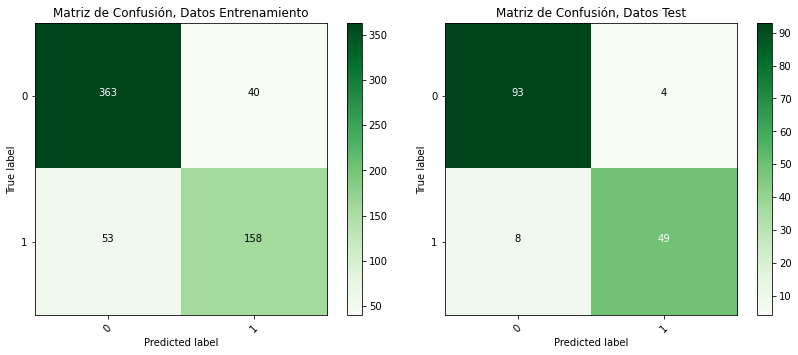

In [28]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Cálculo de las matrices de confusión
confusion_train = confusion_matrix(y_true=y_train,y_pred=logreg.predict(X_train))
confusion_test = confusion_matrix(y_true=y_test,y_pred=logreg.predict(X_test))

# Pintado de las matrices de confusión
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(confusion_train, classes=[0, 1], title='Matriz de Confusión, Datos Entrenamiento')
plt.subplot(1, 2, 2)
plot_confusion_matrix(confusion_test, classes=[0, 1], title='Matriz de Confusión, Datos Test')
plt.show()

<hr>
 
## 5. Conclusiones y Justificación de los resultados

+ El problema de partida en este analisis, eran los datos faltantes (los ceros: destando el 48,7% de la variable insulina, fundamental en este análisis). Hice este modelo previamente sin correcciones de ceros y obtenía una cobertura de sólo un 45%. 

+ Sin embargo, con los cambios realizados, observamos que los ***valores resultantes de la evalución del modelo*** tanto con los datos de entrenamiento cono con test, son *** muy positivos***, llegando incluso a superar los ratios con los datos de test: 

    + Accuracy en train de un 85% en train y alcanza un 92% con datos de test.
    + Precision: De los que he predicho como enfermos son verdad un 80% en train y un 92% en test.
    + Recall: Sobre los casos reales de enfermos, tengo un cobertura  de un del 75% en train y un 86% en test. 
    + F1: La ponderación a la baja de Precision y Recall, resultante llega a ser de hasta un 89% con los casos de test. 


+ los modelos tanto con los datos de test como de entrenamiento son muy similares entre sí (siendo ligeramente superiores en test), con lo que podemos concluir que el algoritmo de aprendizaje con los datos disponibles, genera un modelo muy robusto que generaliza bastante bien.

<hr>

*Este Notebook ha sido desarrollado por **Aranza García Boronat**  estudiante del Máster de Big Data & Data Science de la Utad.
